In [1]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\262272G\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\262272G\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\262272G\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS':'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# safe imports
import sys                  # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    import xarray as xr
    import dask
    import rasterio
    import pystac_client
    from odc import stac
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    import cog_odc
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise

ModuleNotFoundError: No module named 'pystac_client'

In [2]:
# imports
import os
import shutil
import tempfile
import certifi
import arcpy

In [3]:
# set default gdal and certifi envs... improve?
os.environ['GDAL_DATA']  = r'C:\Program Files\ArcGIS\Pro\Resources\pedata\gdaldata'
os.environ.setdefault("CURL_CA_BUNDLE", certifi.where())

'C:\\Users\\262272G\\AppData\\Local\\.certifi\\cacert.pem'

In [4]:
def fetch_odc_xr(collections, in_from_date, in_to_date, bbox, bands, in_epsg, in_res, like):


    # call stac query
    items = cog_odc.fetch_stac_items_odc(stac_endpoint='https://explorer.sandbox.dea.ga.gov.au/stac', 
                                         collections=collections, 
                                         start_dt=in_from_date, 
                                         end_dt=in_to_date, 
                                         bbox=bbox,
                                         slc_off=False,
                                         limit=250)

    # replace s3 prefix with https for each band - arcgis doesnt like s3
    items = cog_odc.replace_items_s3_to_https(items=items, 
                                              from_prefix='s3://dea-public-data', 
                                              to_prefix='https://data.dea.ga.gov.au')


    # construct an xr of items (lazy)
    try:
        ds = cog_odc.build_xr_odc(items=items,
                                  bbox=bbox,
                                  bands=bands,
                                  crs=in_epsg,
                                  resolution=in_res,
                                  group_by='solar_day',
                                  skip_broken_datasets=True,
                                  like=like,
                                  chunks={})

    except:
        arcpy.AddError('Could not build xr dataset via odc-stac.')
        raise

    # convert whole dataset from uint16 to int16 (to handle -999 nodata)
    ds = cog_odc.convert_type(ds=ds, to_type='int16')

    # change nodata value from 0 to -999 to align with original cog method
    ds = cog_odc.change_nodata_odc(ds=ds,
                                   orig_value=0, 
                                   fill_value=-999)

    # correct xr dataset datetimes for arcgis compatiability
    ds = cog_odc.fix_xr_time_for_arc_cog(ds)
    
    return ds

In [5]:
# need button to create shapefile with relevent attributes
# set a folder
# create a shapefile of polygons
# need a id field, out netcdf, platform, start/end monitor date, other

def create_new_nrt_project(out_shp):
    """
    
    """

    # get input shapefile file, get dir and filename
    out_path = os.path.dirname(out_shp)
    out_name = os.path.basename(out_shp)

    # create folder to store future nc files
    nc_path = os.path.join(out_path, 'nc_data')

    # notify
    print('Creating new monitoring shapefile.')

    # create new shapefile in folder for wgs84
    srs = arcpy.SpatialReference(4326)
    arcpy.CreateFeatureclass_management(out_path=out_path, 
                                        out_name=out_name,
                                        geometry_type='POLYGON',
                                        spatial_reference=srs)

    # add new fields
    arcpy.AddField_management(out_shp, 'AreaID', 'LONG')
    arcpy.AddField_management(out_shp, 'NetCDF', 'TEXT')
    arcpy.AddField_management(out_shp, 'Platform', 'TEXT')
    arcpy.AddField_management(out_shp, 'VegIdx', 'TEXT')
    arcpy.AddField_management(out_shp, 'YrStart', 'LONG')
    arcpy.AddField_management(out_shp, 'YrEnd', 'LONG')

    # if nc path already exists, drop it
    if os.path.exists(nc_path):
        try:
            shutil.rmtree(nc_path)
        except:
            raise ValueError('Could not delete {}'.format(nc_path))

    # create new folder
    os.makedirs(nc_path)
    
    # notifty
    print('Created new NRT project and shapefile successfully.')
    
    
# create new nrt project folder and shapefile
out_shp = r'C:\Users\262272G\Desktop\tester\royhill_monitor.shp'
#create_new_nrt_project(out_shp)

In [8]:
# create roi tool
# todo - want soemthing basic but interact. c#?
# user will draw shapes, assign attributes, save, etc


In [32]:
# monitor tool
# select shapefile
# run checks
# loop through each record in shapefile
# get date time of last time
# query stac for all dates above this
# if new records, create new netcdf using odc-stac like func for bb, etc
# append to existing netcdf and save

# get input shapefile file, get dir and filename
out_path = os.path.dirname(out_shp)
out_name = os.path.basename(out_shp)

fields = ['AreaID', 'NetCDF', 'Platform', 'VegIdx', 'YrStart', 'YrEnd', 'Shape@']
with arcpy.da.UpdateCursor(out_shp, fields) as cursor:
    for row in cursor:
        area_id = row[0]
        nc = row[1]
        platform = row[2]
        veg_idx = row[3]
        year_start = row[4]
        year_end = row[5]
        geom = row[6]

        # temp
        in_epsg = 3577
        in_res = 30

        # get as bbox
        bbox = [geom.extent.XMin, geom.extent.YMin, 
                geom.extent.XMax, geom.extent.YMax]
        
        # get collections and bands based on platform
        if platform == 'Landsat':
            collections = ['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3']
            bands = ['nbart_red', 'nbart_green', 'nbart_blue']
        else:
            raise ValueError('Not yet implemented')

        # if netcdf field is empty, add path to row
        if nc == ' ' or nc == '' or nc is None:
            
            # notify
            print('Querying stac for new Area ID: {}'.format(area_id))
            
            # update row with nc path
            out_nc_path = os.path.join(out_path, 'area_{}.nc'.format(area_id))
            row[1] = out_nc_path
            
            # get dates
            in_from_date = '{}-01-01'.format(year_start)
            #in_to_date = '{}-12-31'.format(datetime.now().year)  # testing
            in_to_date = '2020-03-01'
            
            # notify
            print('Getting new data for period: {} to {}'.format(in_from_date, in_to_date))
            
            # get me the data!
            ds = fetch_odc_xr(collections=collections, 
                              in_from_date=in_from_date, 
                              in_to_date=in_to_date, 
                              bbox=bbox, 
                              bands=bands, 
                              in_epsg=3577, 
                              in_res=30, 
                              like=None)
                
            # download and export netcdf to output folder
            with rasterio.Env(**rasterio_env):
                tools.export_xr_as_nc(ds=ds, filename=out_nc_path)
           
        else:
            # notify
            print('Querying stac for existing Area ID: {}'.format(area_id))
            
            # get output nc path
            out_nc_path = nc
            
            # load existing netcdf
            ds_old = xr.open_dataset(out_nc_path)
                  
            # notify
            print('Existing cube has {} images'.format(len(ds_old['time'])))
            
            # get latest datetime from ds old
            latest_dt = ds_old.isel(time=-1)
            in_from_date = str(latest_dt['time'].dt.strftime('%Y-%m-%d').values)                                    
            
            # get now
            in_to_date = '{}-12-31'.format(datetime.now().year)  # testing
            #in_to_date = '2021-06-01'
            
            
                   
            # notify
            print('Adding data for period: {} to {}'.format(in_from_date, in_to_date))
                  
            # get me the data!
            ds_new = fetch_odc_xr(collections=collections, 
                                  in_from_date=in_from_date, 
                                  in_to_date=in_to_date, 
                                  bbox=bbox, 
                                  bands=bands, 
                                  in_epsg=None, 
                                  in_res=None, 
                                  like=ds_old)
                  
            # notify
            print('New cube has {} images'.format(len(ds_new['time'])))
            
            # download and compute
            with rasterio.Env(**rasterio_env):
                ds_new = ds_new.compute()            
            
            # combine but exclude duplicates CHECK THIS CAREFULLY
            ds_old = ds_old.combine_first(ds_new)
                  
            # notify
            print('Newly synced cube now has {} images'.format(len(ds_old['time'])))
                  
            # export new to named file temp, close old, then overwrite
            with tempfile.NamedTemporaryFile() as tmp:
                ds_old.to_netcdf(tmp.name + '.nc')
                
                ds_old.close()
                ds_new.close()
                del ds_old
                del ds_new
                
                ds = xr.open_dataset(tmp.name + '.nc')
                
                ds.to_netcdf(out_nc_path)

            
        # update cursor regardless
        cursor.updateRow(row)


Querying stac for existing Area ID: 1
Existing cube has 361 images
Adding data for period: 2021-05-21 to 2021-12-31
Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
A total of 20 scenes were found.
Replacing url prefix: s3://dea-public-data with https://data.dea.ga.gov.au
Converting raw STAC data into xarray dataset via odc-stac.
Created xarray dataset via odc-stac successfully.
New cube has 20 images
Newly synced cube now has 380 images
Querying stac for existing Area ID: 2
Existing cube has 361 images
Adding data for period: 2021-05-21 to 2021-12-31
Beginning STAC search for items. This can take awhile.
Searching collection: ga_ls5t_ard_3
Searching collection: ga_ls7e_ard_3
Excluding SLC-off times.
Searching collection: ga_ls8c_ard_3
A total of 20 scenes were found.
Replacing url prefix: s3://dea-public-data with https://data.dea.ga.gov.au
Convert

In [33]:
# for each dataset, we need to re-run ewmacd
# output ewmacd netcdfs for each area similar to above

<xarray.Dataset>
Dimensions:      (time: 582, x: 31, y: 15)
Coordinates:
  * time         (time) datetime64[ns] 2005-01-10T01:42:55 ... 2021-11-06T01:...
  * y            (y) float64 -2.518e+06 -2.518e+06 ... -2.519e+06 -2.519e+06
  * x            (x) float64 -1.29e+06 -1.29e+06 ... -1.289e+06 -1.289e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float64 ...
    nbart_green  (time, y, x) float64 ...
    nbart_blue   (time, y, x) float64 ...
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [6]:
# loop each ewmacd output and detect traffic lights
# need to experiment here

In [7]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# testing: load dataset
ds = xr.open_dataset(r"C:\Users\262272G\Curtin\GDVII - General\Work Package 2\Analysis\EWMACD\yandi pump\yandi_pump_train_90_95_per1_clean.nc")

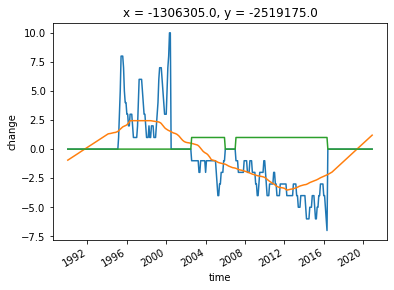

In [11]:
#test = [10, 20]
test = [30, 20]

vec = ds['change'].isel(x=test[0], y=test[1])

# create neg only mask
n_vec = vec.copy(deep=True)  
n_vec.data = vec < 0
n_vec = n_vec.astype(int) #* -1

# create smoothed original vec
s_vec = vec.copy(deep=True)
s_vec.data = savgol_filter(vec, 99, 1)

vec.plot()
s_vec.plot()
n_vec.plot()

plt.show()

[  0.         114.62923984 204.         316.40700559 316.62358751
 371.        ]


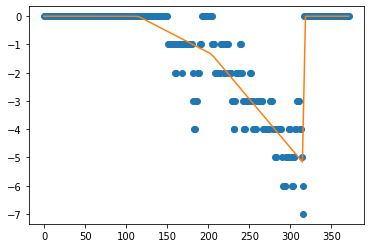

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pwlf

x = np.arange(0, len(vec))
y = np.where(np.array(vec) < 0, np.array(vec), 0)

my_pwlf = pwlf.PiecewiseLinFit(x, y)
breaks = my_pwlf.fit(5)
print(breaks)

x_hat = np.linspace(x.min(), x.max(), 100)
y_hat = my_pwlf.predict(x_hat)

plt.figure()
plt.plot(x, y, 'o')
plt.plot(x_hat, y_hat, '-')
plt.show()

In [265]:
# loop through neg only mask and count
out = []
for cv in n_vec:
    cv = cv.values
    
    if len(out) > 0:
        if cv == 1:
            out.append(cv + out[-1])
        else:
            out.append(0)
    
    else:
        out.append(0)
    
out = np.array(out) * -1
plt.plot(np.arange(0, len(out)), out)
plt.show()

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [160]:
diffs = np.diff(s_vec)

In [165]:
plt.plot(diffs)
plt.show()

In [120]:
# check if value is negative or positive
negs = diffs < 0
negs

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [125]:
def find_runs(x):
    """Find runs of consecutive items in an array."""

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        return run_values, run_starts, run_lengths

In [145]:
run_vals, run_starts, run_lengths = find_runs(diffs < 0)

In [146]:
run_vals, run_starts, run_lengths

(array([False,  True, False]), array([  0, 101, 267], dtype=int64), array([101, 166, 104], dtype=int64))

In [174]:
for e in vec:
    print(e.values)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
1.0
3.0
5.0
8.0
8.0
8.0
7.0
5.0
4.0
4.0
3.0
3.0
2.0
2.0
3.0
3.0
3.0
2.0
1.0
1.0
1.0
1.0
1.0
2.0
4.0
6.0
6.0
6.0
6.0
5.0
4.0
3.0
3.0
2.0
1.0
1.0
1.0
2.0
1.0
1.0
2.0
2.0
2.0
1.0
1.0
1.0
2.0
3.0
4.0
6.0
7.0
7.0
7.0
6.0
5.0
4.0
3.0
3.0
3.0
5.0
7.0
8.0
10.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-2.0
-2.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-2.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-2.0
-3.0
-4.0
-4.0
-3.0
-3.0
-2.0
-2.0
-2.0
-1.0
-1.0
-0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-1.0
-1.0
-1.0
-2.0
-2.0
-2.0
-2.0
-2.0
-2.0
-2.0
-1.0
-1.0
-1.0
-1.0
-2.0
-2.0
-2.

In [184]:
#for e in np.diff(vec):
    #print(e)

In [ ]:
# diff good for detecting sharp or subtle declines

In [ ]:
# cutt off all positive change values and set to 0
# if we include positives, we could detect decline after a large rainfall epriod that is still positive


In [229]:
out = []
for i in np.arange(0, len(vec)):
    current_val = vec[i].values
    
    if len(out) == 0:
        out.append(0)
        continue
        
    # we only want neg change
    # no decline within positive area of change (i.e. declining regrowth after rainfall)
    if current_val <= 0:
        
        # current value is less than previous negative
        if current_val < vec[i - 1]:
            out.append(-1)
    
        # current value is same as previous negative
        elif current_val == vec[i - 1]:
            out.append(0)
            
        elif current_val > vec[i - 1]:
            out.append(1)
            
        else:
            out.append(-999)
        
    else:
        out.append(0)
        

out

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 1, 0, 0, -1, 0, 0, 0, -1, 0, -1, 0, 1, 1, 0, 0, 0, 0, 1, 0, -1, -1, -1, 0, 0, 1, 0, 0, 0, 0, 1, 0, -1, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 1, 0, 0, 1, 0, 0, -1, -1, 0, 1, 0, 1, 0, 1, 0, 0, 0, -1, 0, -1, -1, -1, 1, 0, 0, 0, 0, 0, 0

In [231]:
plt.plot(out)
plt.show()

In [21]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\262272G\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\262272G\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\262272G\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS':'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# safe imports
import sys                  # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    import xarray as xr
    import dask
    import rasterio
    #import pystac_client
    #from odc import stac
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    #import cog_odc
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise

In [14]:
import os
import xarray as xr


folder = r"C:\Users\262272G\Desktop\workshop_data\new\phenometrics\tifs"
for root, dirs, files in os.walk(folder):
    ...

ds_list = []
for file in files:
    if file.endswith('.tif'):
        filepath = os.path.join(root, file)
        
        ds = xr.open_rasterio(filepath).to_dataset('band')
        
        ds = ds.rename({1: file.replace('.tif', '')})
        ds_list.append(ds)

In [15]:
ds = xr.merge(ds_list, combine_attrs='override')

In [5]:
#ds_template = xr.open_dataset(r"C:\Users\262272G\Desktop\output\test.nc")

In [22]:
ds = xr.open_dataset(r'C:\Users\262272G\Desktop\workshop_data\old\sdm\sdm_lidar_1000pa_removed_vif_vars.nc')

In [23]:
ds = tools.build_xr_attributes(ds)

Could not manually create dataset attributes.


In [33]:
ds.attrs.update({'crs': 'EPSG:3577'})

In [36]:
ds = build_xr_attributes(ds)

In [17]:
ds = ds.where(ds != ds.nodatavals[0], np.nan)

In [38]:
ds.attrs.update({'nodatavals': np.nan})

In [40]:
ds.attrs.update({'res': 1})

In [41]:
ds.to_netcdf(r'C:\Users\262272G\Desktop\workshop_data\new\sdm\nc\sdm.nc')

In [42]:
ds = ds.where(~ds.isnull(), -999)

In [43]:
ds.attrs.update({'nodatavals': -999})

In [45]:
ds.to_netcdf(r'C:\Users\262272G\Desktop\workshop_data\new\sdm\nc\sdm_temp.nc')

In [13]:
ds_attrs = ds_esri.attrs

In [9]:
import xarray
import matplotlib.pyplot as plt


In [13]:
ds = xr.open_rasterio(r"C:\Users\262272G\Curtin\GDVII - General\Work Package 1\Dempster\royhill_final\sentinel\tifs\sdm.tif")
ds = ds.compute()
ds

ds.plot(robust=True)
plt.show()

KeyboardInterrupt: 

In [17]:
ds = xr.open_dataset(r'C:\Users\262272G\Desktop\workshop_data\old\sdm\sdm_lidar_1000pa_removed_vif_vars.nc')
ds['sdm_mean'].plot(robust=True)
plt.show()